In [2]:
import os

import numpy as np
import scipy
import pandas as pd

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_folder_path = ''
file_identifier = '.json'
data_set = {}
for folder in os.listdir(data_folder_path):
    for file in os.listdir(data_folder_path + '/' + folder):
        if file.endswith(file_identifier):
            test = data_folder_path + '/' + folder + '/' + file
            data_set[file] = pd.read_json(data_folder_path + '/' + folder + '/' + file)

In [4]:
group_dict = {}

for key in data_set:
    keywords = key.split("_")
    subject_identifier = keywords[-1].replace(".json", "")
    network_typ = 'CNN'
    if keywords[1] == 'RNN':
        network_typ = 'RNN'

    group_dict[key] = {'subject_identifier': subject_identifier, 'network_typ': network_typ,
                       'accuracy': data_set.get(key)[0].get("accuracy")}

In [5]:
test_frame = pd.DataFrame(group_dict).T

In [6]:
grouped_dataframe = pd.DataFrame(columns=['subject_identifier', 'cnn_accuracy', 'rnn_accuracy'])
for key in test_frame.groupby('subject_identifier'):
    grouped_dataframe = pd.concat([grouped_dataframe,
                                   pd.DataFrame(
                                       {'subject_identifier': key[0],
                                        'cnn_accuracy': key[1].loc[key[1]['network_typ'] == 'CNN', 'accuracy'][0],
                                        'rnn_accuracy': key[1].loc[key[1]['network_typ'] == 'RNN', 'accuracy'][0]
                                        }, index=['subject_identifier']
                                   )
                                   ], ignore_index=True)

In [7]:
pprint(grouped_dataframe)

   subject_identifier  cnn_accuracy  rnn_accuracy
0             General      0.200513          0.20
1            Sample01      0.340000          0.14
2            Sample02      0.440000          0.28
3            Sample03      0.680000          0.16
4            Sample04      0.200000          0.14
5            Sample05      0.620000          0.26
6            Sample06      0.380000          0.16
7            Sample07      0.540000          0.10
8            Sample08      0.560000          0.30
9            Sample09      0.380000          0.22
10           Sample10      0.480000          0.22
11           Sample11      0.640000          0.22
12           Sample12      0.540000          0.28
13           Sample13      0.360000          0.28
14           Sample14      0.420000          0.20
15           Sample15      0.400000          0.24


In [8]:
grouped_df_without_general = grouped_dataframe[grouped_dataframe['subject_identifier'] != 'General']

In [9]:
cnn_accuracy_list = grouped_df_without_general.get('cnn_accuracy').to_list()
rnn_accuracy_list = grouped_df_without_general.get('rnn_accuracy').to_list()

CNN: mean: 0.4653 ; std: 0.1264 n = 15
RNN: mean: 0.2133 ; std: 0.0596 n = 15


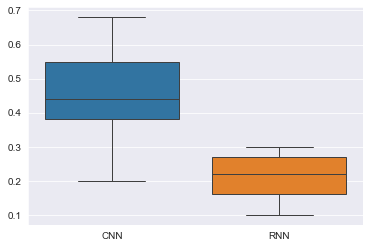

CNN Shapiro-Wilk p-value: 0.8319
RNN Shapiro-Wilk p-value: 0.3714
Levene's test p-value: 0.016
Mann-Whitney U test p-value: 2.0657484497919397e-05


In [10]:
# Descriptive statistik
print(f'CNN: mean: {np.round(np.mean(cnn_accuracy_list), 4)} ; std: {np.round(np.std(cnn_accuracy_list), 4)} n = {len(cnn_accuracy_list)}')
print(f'RNN: mean: {np.round(np.mean(rnn_accuracy_list), 4)} ; std: {np.round(np.std(rnn_accuracy_list), 4)} n = {len(cnn_accuracy_list)}')

# visualisation of the data 
sns.boxplot(data=[cnn_accuracy_list, rnn_accuracy_list])
plt.xticks([0, 1], ['CNN', 'RNN'])
plt.show()

# Test for normaldistribution 
_, p_value1 = scipy.stats.shapiro(cnn_accuracy_list)
_, p_value2 = scipy.stats.shapiro(rnn_accuracy_list)
print(f"CNN Shapiro-Wilk p-value: {np.round(p_value1,4)}")
print(f"RNN Shapiro-Wilk p-value: {np.round(p_value2,4)}")

# Test for variance homogeneity 
_, p_value_levene = scipy.stats.levene(cnn_accuracy_list, rnn_accuracy_list)
print(f"Levene's test p-value: {np.round(p_value_levene,4)}")

# Choosing of the right test
if p_value1 > 0.05 and p_value2 > 0.05 and p_value_levene > 0.05:
    # t-Test
    t_stat, p_value_ttest = scipy.stats.ttest_ind(cnn_accuracy_list, rnn_accuracy_list)
    print(f"t-Test p-value: {np.round(p_value_ttest,4)}")
else:
    # Mann-Whitney-U-Test
    u_stat, p_value_mannwhitney = scipy.stats.mannwhitneyu(cnn_accuracy_list, rnn_accuracy_list)
    print(f"Mann-Whitney U test p-value: {p_value_mannwhitney}")


In [11]:
# Creation of the bootstrap method for the comparison of the grouped data networks to the individual networks

def bootstrap_confidence_interval(
        data, num_iterations=10000, confidence_level=0.95, random_seed=0
):
    np.random.seed(random_seed)
    bootstrap_samples = np.random.choice(data, size=(num_iterations, len(data)), replace=True)
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    lower_bound = np.percentile(bootstrap_means, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(bootstrap_means, (1 + confidence_level) / 2 * 100)
    return lower_bound, upper_bound

In [12]:
bootstrap_list = [
    ('cnn_accuracy', grouped_dataframe.get(['subject_identifier', 'cnn_accuracy']))
    , ('rnn_accuracy', grouped_dataframe.get(['subject_identifier', 'rnn_accuracy']))
]

In [13]:
# Comparison of the conditions

# for condition in bootstrap_list:
for condition in bootstrap_list:
    condition_name = condition[0]
    condition_values = condition[1]
    group_general = condition_values[(condition_values['subject_identifier'] == 'General')][condition_name].values
    group_individual = condition_values[(condition_values['subject_identifier'] != 'General')][condition_name].values

    if len(group_general) == 1:
        value_of_general_data = group_general[0]
        mean_gruppe_b = np.mean(group_individual)
        conf_interval = bootstrap_confidence_interval(group_individual)
        significant_text = ""
        
        if value_of_general_data < conf_interval[0] or value_of_general_data > conf_interval[1]:
            significant_text = " and that the difference of the mean value is significant."
        else:
            significant_text = ", but that the difference of the mean values are not significant."
            
        print(
            f"For the condition of the {condition_name[:3].upper()}-networks we can observer that the single value from the general group is {round(value_of_general_data, 4)} and the mean value from the individual group is {round(mean_gruppe_b, 4)} and the limits of the 95% confidence interval for individual group are {round(conf_interval[0], 4)} and {round(conf_interval[1], 4)}{significant_text}")

        print()



For the condition of the CNN-networks we can observer that the single value from the general group is 0.2005 and the mean value from the individual group is 0.4653 and the limits of the 95% confidence interval for individual group are 0.4 and 0.5293 and that the difference of the mean value is significant.

For the condition of the RNN-networks we can observer that the single value from the general group is 0.2 and the mean value from the individual group is 0.2133 and the limits of the 95% confidence interval for individual group are 0.1827 and 0.2427, but that the difference of the mean values are not significant.
